# Libary imports

In [32]:
import os
import json
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

# Getting the Data

Based on a project by [Victor Soeiro](https://github.com/victor-soeiro).

In [2]:
# Select the streamings plattaforms you want
streamings = {
    'amazon':'amp',
    'disney':'dnp',
    'hbo':'hbm',
    'netflix':'nfx',
    'paramount':'pmp',
    'appletv':'atp'
}

In [3]:
#The URL to extract the titles
url = "https://apis.justwatch.com/graphql"

In [4]:
#Specifying the User-Agent
headers = {
    "content-type": "application/json",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36",
    "accept-encoding": "gzip, deflate, br"
}

In [5]:
#Getting the post data
with open('src/postData.json','r',encoding='utf-8') as file:
    postData = json.load(file)

In [6]:
#Getting the query
with open('src/query.graphql', 'r', encoding='utf-8') as file:
    query = file.read()

In [7]:
postData['query'] = query

In [8]:
def setStreaming(plataform):
    """
    A function that sets the streaming on query variables.
    """
    
    postData['variables']['popularTitlesFilter']['packages'] = [streamings[plataform ]]

In [9]:
#REkeased year filter
releasedYear =  [1899, 1950, 1980, 1990, 2000, 2010, 2012, 2014, 2016, 2018, 2020, 2022, 2023]

In [10]:
def getTitles(platform, cursor = None, titles = None, start = True):
    """ 
     Funciton that gets all titles available of a platform. 
    """
    
    if not titles:
        titles = []
        
    if cursor and not start:
        postData['variables']['popularAfterCursor'] = cursor
    else:
        postData['variables']['popularAfterCursor'] = ""
        
    setStreaming(platform)
    
    ret = requests.post(url, data=json.dumps(postData), headers=headers)
    if ret.status_code != 200:
        raise requests.ConnectionError('Connection failed')
        sys.exit(-1)
    
    results = ret.json()['data']['popularTitles']
    titles.extend(results['edges'])
    
    if results['pageInfo']['hasNextPage']:
        cursor = results['pageInfo']['endCursor']
        getTitles(platform=platform, cursor=cursor, titles=titles, start=False)

    return titles

In [11]:
def titleContentParser(title):
    """ 
    A function that parses the title content to a dictionary. 
    """

    show = title['node']

    content = {}
    content['id'] = show['id']
    content['title'] = show['content']['title']
    content['type'] = show['objectType']
    content['description'] = show['content']['shortDescription']
    content['release_year'] = show['content']['originalReleaseYear']
    content['age_certification'] = show['content']['ageCertification']
    content['runtime'] = show['content']['runtime']
    content['genres'] = [i['technicalName'] for i in show['content']['genres']]
    content['production_countries'] = show['content']['productionCountries']
    content['seasons'] = show.get('totalSeasonCount', None)
    content['imdb_id'] = show['content']['externalIds']['imdbId']
    content['imdb_score'] = show['content']['scoring']['imdbScore']
    content['imdb_votes'] = show['content']['scoring']['imdbVotes']
    content['tmdb_popularity'] = show['content']['scoring']['tmdbPopularity']
    content['tmdb_score'] = show['content']['scoring']['tmdbScore']

    credits = [
        {
            'person_id': i['personId'],
            'id': content['id'],
            'name': i['name'],
            'character': i['characterName'],
            'role': i['role']
        } for i in show['content']['credits']
    ]

    return content, credits

In [12]:
def saveData(data, save = True, path = ''):
    """ 
    Function that parses a list of titles and saves it to a file. 
    """
    
    titles = []
    credits = []
    
    for title in data:
        content, credit = titleContentParser(title)
        titles.append(content)
        credits.extend(credit)
        
    if save:
        titlesDf = pd.DataFrame(titles)
        creditsDf = pd.DataFrame(credits)
            
        titlesDf.to_csv(path+'titles.csv', index=False)
        creditsDf.to_csv(path+'credits.csv', index=False)
        
    return titles, credits #To enable to see the data if save=False

In [13]:
def getPlatformTitles(platform, save=True):
    """ 
    A function that gets all titles available on a given platform.
    """
    
    raw = []
    for i in range(len(releasedYear) - 1):
        filterRange = {'min': releasedYear[i]+1, 'max': releasedYear[i+1]}
        
        postData['variables']['popularTitlesFilter']['releaseYear'] = filterRange  # Set the filter
        
        yearTitles = getTitles(platform=platform)
        raw.extend(yearTitles)
    
    if save:
        filePath = f'../app/data/{platform}/' #Force to put the data in the 'data' directory
        if not os.path.exists(filePath):
            os.mkdir(filePath)
            
    titles, credits = saveData(data=raw, save=save, path=filePath)
    
    return titles, credits #To enable to see the data if save=False

In [14]:
def main():
    data = {} #If you want to use de data after
    for platform in tqdm(streamings.keys()):
        titles, credits = getPlatformTitles(platform=platform, save=True,)
        
        data[platform] = {
            'titles': titles,
            'credits': credits
        }
        
        print(f"Titles in {platform}: {len(data[platform]['titles'])}")
        print(f"Credits in {platform}: {len(data[platform]['credits'])}",end='\n\n')
        
            

In [15]:
main()

  0%|          | 0/6 [00:00<?, ?it/s]

Titles in amazon: 10915
Credits in amazon: 140165

Titles in disney: 1865
Credits in disney: 30576

Titles in hbo: 3112
Credits in hbo: 69345

Titles in netflix: 6154
Credits in netflix: 81816

Titles in paramount: 3154
Credits in paramount: 50278

Titles in appletv: 170
Credits in appletv: 1740



# Cleaning the Data

## Titles imports

In [18]:
amazon_titles = pd.read_csv("../app/data/amazon/titles.csv")
appletv_titles = pd.read_csv("../app/data/appletv/titles.csv")
disney_titles = pd.read_csv("../app/data/disney/titles.csv")
hbo_titles = pd.read_csv("../app/data/hbo/titles.csv")
netflix_titles = pd.read_csv("../app/data/netflix/titles.csv")
paramount_titles = pd.read_csv("../app/data/paramount/titles.csv")

## Concatenation

In [19]:
titles = pd.concat([amazon_titles, appletv_titles, disney_titles, hbo_titles, netflix_titles, paramount_titles], axis = 0).reset_index()
titles.drop(['index'], axis=1, inplace=True)

In [20]:
# Seeing if we have duplicates
titles[titles.duplicated() == True].head(5)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
2992,tm669124,Night Things,MOVIE,Two women find themselves trapped between life...,2010,NaN,91,"['horror', 'scifi']",['US'],NaN,tt1103272,4.6,121.0,1.153,NaN
2993,ts31759,The Saddle Club,SHOW,The Saddle Club is a children's television ser...,2001,TV-Y,25,['family'],"['AU', 'CA', 'US']",3.0,tt0278876,6.1,1076.0,8.433,6.500
2994,tm55859,Jack and Jill vs. The World,MOVIE,Jack and Jill's Manifesto of Rules to Live By ...,2010,PG-13,89,"['romance', 'comedy', 'drama']",['US'],NaN,tt0475252,5.5,3036.0,5.503,5.200
2995,tm95226,Ties That Bind,MOVIE,Hope finds herself leaving the comfort of her ...,2010,NaN,90,"['thriller', 'crime']",['CA'],NaN,tt1615110,5.0,341.0,5.306,4.200
3352,tm77863,Honeymoon Travels Pvt. Ltd.,MOVIE,"Six newly-married, diverse, honeymooning coupl...",2007,PG-13,118,"['comedy', 'drama', 'romance']",['IN'],NaN,tt0808306,6.1,2748.0,4.777,5.273


In [21]:
# Dropping duplicates
titles.drop_duplicates(inplace=True)

In [22]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,tm87233,It's a Wonderful Life,MOVIE,A holiday favourite for generations... George...,1946,PG,130,"['drama', 'family', 'fantasy', 'romance', 'com...",['US'],NaN,tt0038650,8.6,468814.0,35.635,8.264
1,tm38206,Whoopee!,MOVIE,Western sheriff Bob Wells is preparing to marr...,1930,NaN,93,"['comedy', 'romance', 'western']",['US'],NaN,tt0021549,6.4,1091.0,1.448,7.000
2,tm143047,Duck Soup,MOVIE,Rufus T. Firefly is named president/dictator o...,1933,NaN,69,"['comedy', 'war']",['US'],NaN,tt0023969,7.8,61085.0,11.664,7.300
3,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,NaN,92,"['romance', 'drama', 'comedy']",['US'],NaN,tt0032599,7.8,60412.0,12.582,7.400
4,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934,TV-PG,19,"['comedy', 'family']",['US'],26.0,tt0850645,8.5,1163.0,15.424,7.600


## Seeing how many null values

First, let's see how many non-null values we have for each column

In [23]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23483 entries, 0 to 25369
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    23483 non-null  object 
 1   title                 23483 non-null  object 
 2   type                  23483 non-null  object 
 3   description           23301 non-null  object 
 4   release_year          23483 non-null  int64  
 5   age_certification     11466 non-null  object 
 6   runtime               23483 non-null  int64  
 7   genres                23483 non-null  object 
 8   production_countries  23483 non-null  object 
 9   seasons               5672 non-null   float64
 10  imdb_id               21538 non-null  object 
 11  imdb_score            20930 non-null  float64
 12  imdb_votes            20869 non-null  float64
 13  tmdb_popularity       22759 non-null  float64
 14  tmdb_score            20527 non-null  float64
dtypes: float64(5), int6

We have some gaps in each column, let's see how many null values are for each column

In [24]:
titles.isna().sum()

id                          0
title                       0
type                        0
description               182
release_year                0
age_certification       12017
runtime                     0
genres                      0
production_countries        0
seasons                 17811
imdb_id                  1945
imdb_score               2553
imdb_votes               2614
tmdb_popularity           724
tmdb_score               2956
dtype: int64

To get a better understanging of the picture, let's use [missingno](https://github.com/ResidentMario/missingno) to see the missing data in our dataset:

Text(0.5, 1.0, 'Distribution of Missing Values')

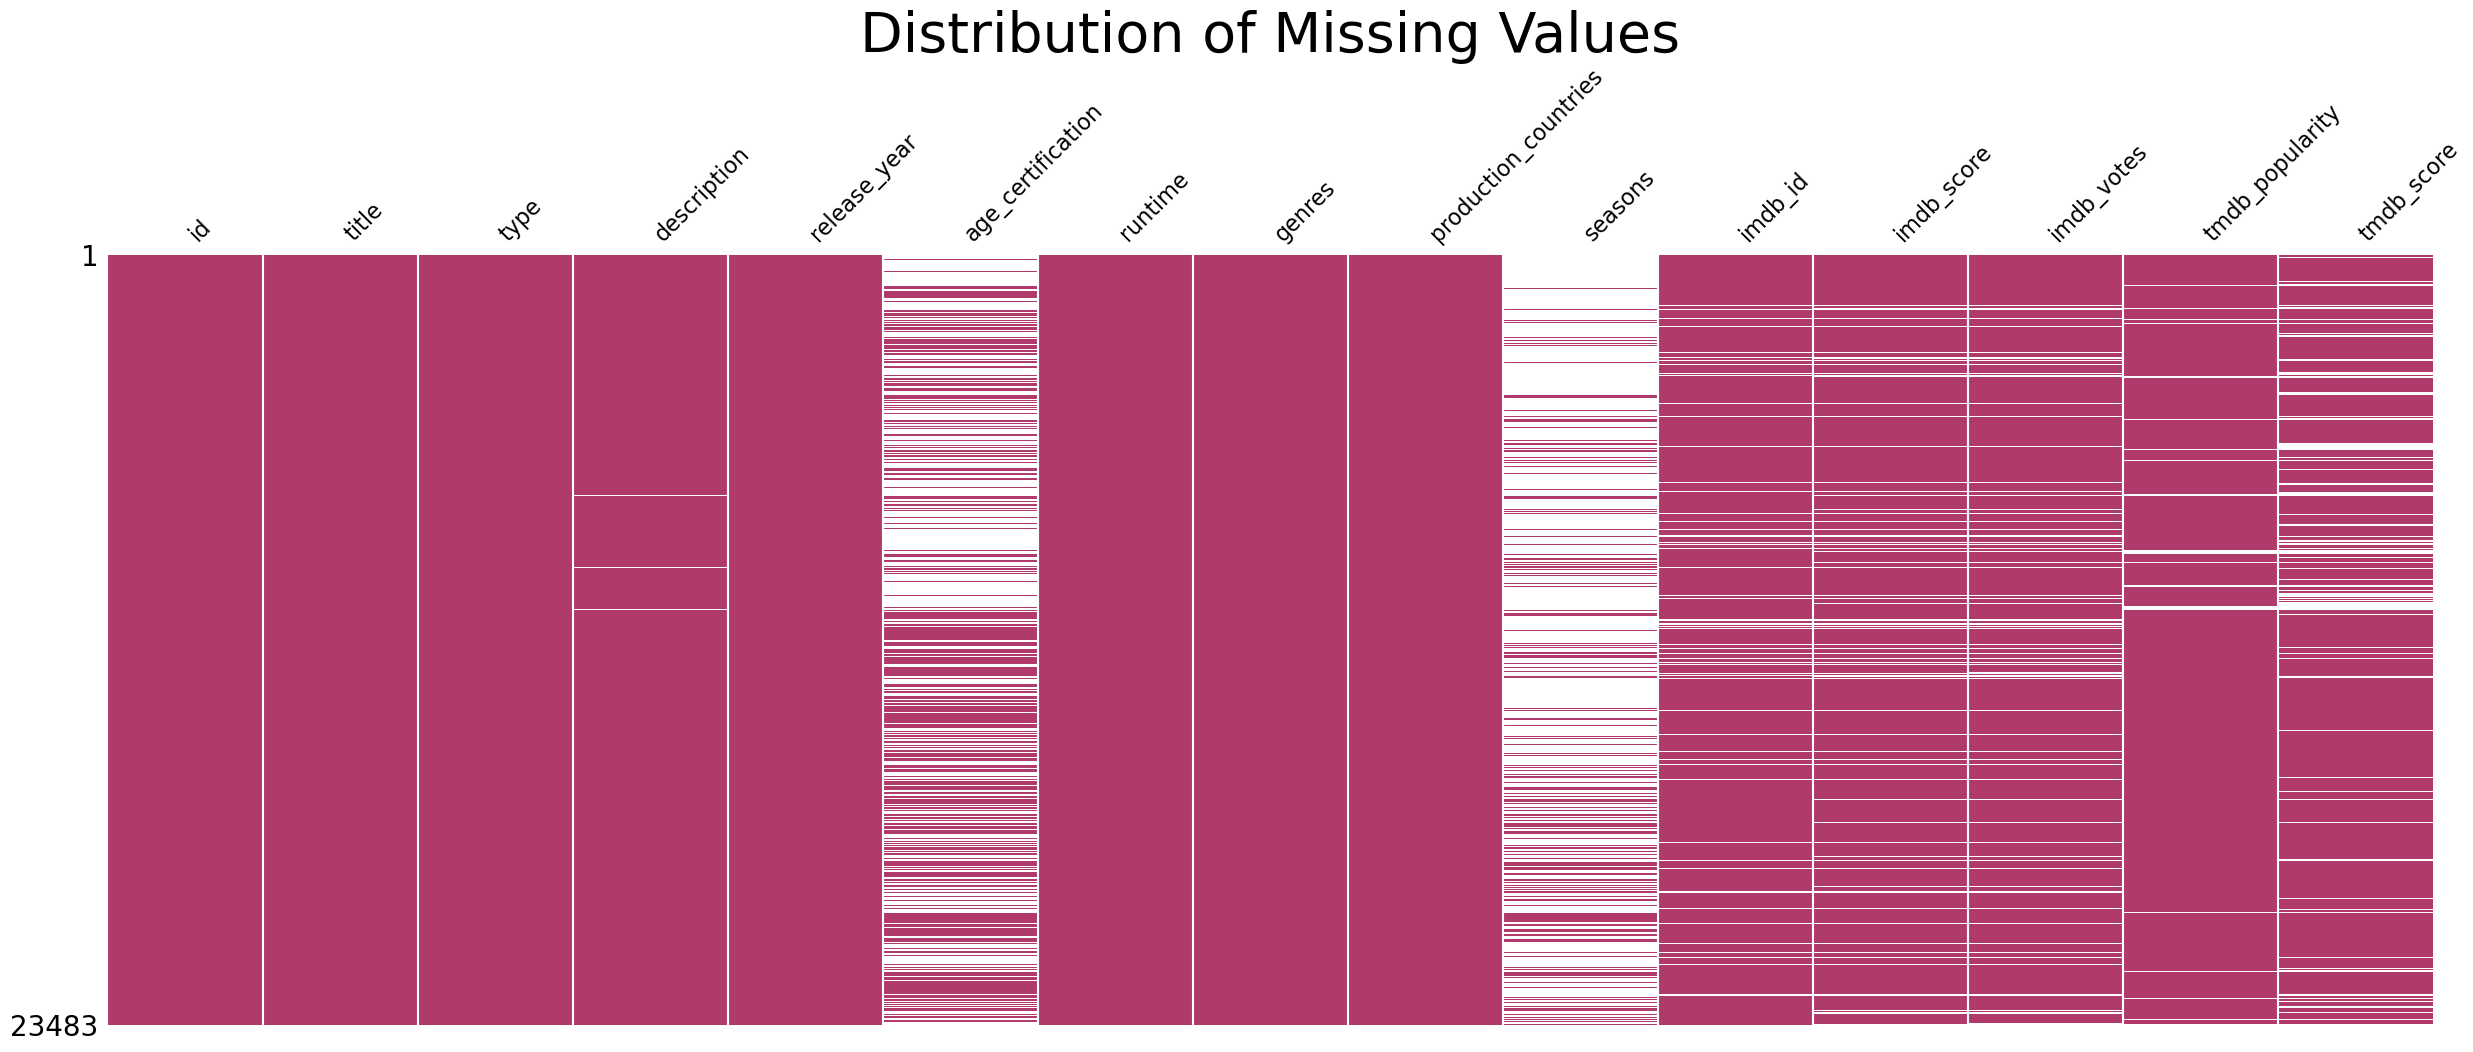

In [25]:
msno.matrix(titles, sparkline=False, figsize=(30,10), color=(0.69,0.23,0.42))
plt.title('Distribution of Missing Values', fontsize=40)

## Handling the 'genres' and 'production_countries' columns

These two columns are formed by list values, so we need to handle these values to work with a single value.

In [26]:
# For genres
titles['genres'] = titles['genres'].str.replace(r'[','').str.replace(r"'",'').str.replace(r']','')
titles['genre'] = titles['genres'].str.split(',').str[0]

# For countries
titles['production_countries'] = titles['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
titles['production_country'] = titles['production_countries'].str.split(',').str[0]


C:\Users\diego\AppData\Local\Temp\ipykernel_3680\2497750954.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  titles['genres'] = titles['genres'].str.replace(r'[','').str.replace(r"'",'').str.replace(r']','')
C:\Users\diego\AppData\Local\Temp\ipykernel_3680\2497750954.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  titles['production_countries'] = titles['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')


In [27]:
titles.drop(['genres', 'production_countries'], axis=1, inplace=True)

In [28]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre,production_country
0,tm87233,It's a Wonderful Life,MOVIE,A holiday favourite for generations... George...,1946,PG,130,NaN,tt0038650,8.6,468814.0,35.635,8.264,drama,US
1,tm38206,Whoopee!,MOVIE,Western sheriff Bob Wells is preparing to marr...,1930,NaN,93,NaN,tt0021549,6.4,1091.0,1.448,7.000,comedy,US
2,tm143047,Duck Soup,MOVIE,Rufus T. Firefly is named president/dictator o...,1933,NaN,69,NaN,tt0023969,7.8,61085.0,11.664,7.300,comedy,US
3,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,NaN,92,NaN,tt0032599,7.8,60412.0,12.582,7.400,romance,US
4,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934,TV-PG,19,26.0,tt0850645,8.5,1163.0,15.424,7.600,comedy,US


In [29]:
titles['genre'].unique()

array(['drama', 'comedy', 'romance', 'western', 'history', 'action',
       'thriller', 'fantasy', 'horror', 'war', 'animation',
       'documentation', 'crime', '', 'family', 'music', 'scifi',
       'reality', 'sport', 'european'], dtype=object)

In [30]:
titles['production_country'].unique()

array(['US', 'GB', 'SU', 'DE', 'MX', 'CA', '', 'SE', 'IN', 'HK', 'IT',
       'AU', 'MA', 'FR', 'JP', 'ES', 'PR', 'TW', 'PH', 'LI', 'NL', 'RO',
       'IE', 'KR', 'CI', 'CH', 'YU', 'IL', 'EG', 'RU', 'BD', 'HU', 'ZA',
       'BR', 'CL', 'NZ', 'AR', 'DK', 'CZ', 'IR', 'AT', 'CN', 'BE', 'PT',
       'GH', 'ID', 'VE', 'XC', 'TH', 'NO', 'BG', 'PL', 'CO', 'AE', 'RW',
       'GR', 'AF', 'SK', 'RS', 'JM', 'SG', 'TC', 'UY', 'UA', 'CS', 'MY',
       'LT', 'SA', 'EC', 'NG', 'ZM', 'DO', 'VN', 'TR', 'LV', 'FI', 'DZ',
       'MT', 'GE', 'LU', 'BY', 'PK', 'PE', 'XK', 'IS', 'KE', 'SV', 'LB',
       'CR', 'MN', 'NI', 'PA', 'UZ', 'NA', 'KH', 'CM', 'CU', 'ET', 'EE',
       'JO', 'QA', 'BM', 'NP', 'PF', 'HN', 'NC', 'TN', 'IO', 'MK', 'TT',
       'GT', 'BW', 'SN', 'BS', 'PY', 'BO', 'PS', 'CD', 'CY', 'SY', 'GL',
       'AL', 'KW', 'IQ', 'TZ', 'AO', 'MU', 'ZW'], dtype=object)

We can see that in both columns we have an empty value. Let's fill these values with NaN to make it easier to deal with in the future.

In [33]:
titles['genre'] = titles['genre'].replace('', np.nan)
titles['production_country'] = titles['production_country'].replace('',np.nan)

## Handling the 'seasons' column

Now let's deal with the 'seasons' column. At first glance, we can say that all the null values are of type 'MOVIE'. Let's see if this is true by comparing the number of null values with the number of movie titles that do not have a value in 'seasons'.

In [34]:
len(titles.loc[(titles['seasons'].isna()) & (titles['type'] == 'MOVIE')]) == titles.seasons.isna().sum()

True

So, all the null values from 'season' is from movies. Let's change the null values to 0.

In [35]:
titles['seasons'].fillna(0, inplace=True)

In [36]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre,production_country
0,tm87233,It's a Wonderful Life,MOVIE,A holiday favourite for generations... George...,1946,PG,130,0.0,tt0038650,8.6,468814.0,35.635,8.264,drama,US
1,tm38206,Whoopee!,MOVIE,Western sheriff Bob Wells is preparing to marr...,1930,NaN,93,0.0,tt0021549,6.4,1091.0,1.448,7.000,comedy,US
2,tm143047,Duck Soup,MOVIE,Rufus T. Firefly is named president/dictator o...,1933,NaN,69,0.0,tt0023969,7.8,61085.0,11.664,7.300,comedy,US
3,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,NaN,92,0.0,tt0032599,7.8,60412.0,12.582,7.400,romance,US
4,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934,TV-PG,19,26.0,tt0850645,8.5,1163.0,15.424,7.600,comedy,US


## Handling the rest of the null values

Let's see how many null values are left

In [37]:
titles.isna().sum()

id                        0
title                     0
type                      0
description             182
release_year              0
age_certification     12017
runtime                   0
seasons                   0
imdb_id                1945
imdb_score             2553
imdb_votes             2614
tmdb_popularity         724
tmdb_score             2956
genre                   369
production_country      420
dtype: int64

Now, let's drop the 'imdb_id' and the 'age_certification' columns.

In [38]:
titles.drop(['imdb_id','age_certification'], axis=1,inplace=True)

Let's also get rid of some NaN values that are still left in our dataset.

In [39]:
titles.dropna(inplace=True)

In [40]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18736 entries, 0 to 25368
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  18736 non-null  object 
 1   title               18736 non-null  object 
 2   type                18736 non-null  object 
 3   description         18736 non-null  object 
 4   release_year        18736 non-null  int64  
 5   runtime             18736 non-null  int64  
 6   seasons             18736 non-null  float64
 7   imdb_score          18736 non-null  float64
 8   imdb_votes          18736 non-null  float64
 9   tmdb_popularity     18736 non-null  float64
 10  tmdb_score          18736 non-null  float64
 11  genre               18736 non-null  object 
 12  production_country  18736 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 2.0+ MB


We can see that we still have 18736 values remaining.

# Adding the Streaming Platform for the titles

I am creating a 'streaming_platform' column to present where the titles are available.

In [41]:
lt = []
for i in titles['id']:
    movie_streaming = []
    if i in amazon_titles['id'].values:
        movie_streaming.append('amazon')
    if i in appletv_titles['id'].values:
        movie_streaming.append('appletv')
    if i in disney_titles['id'].values:
        movie_streaming.append('disney+')
    if i in hbo_titles['id'].values:
        movie_streaming.append('hbomax')
    if i in netflix_titles['id'].values:
        movie_streaming.append('netflix')
    if i in paramount_titles['id'].values:
        movie_streaming.append('paramount+')
    lt.append(movie_streaming)

In [42]:
titles['streaming_platform'] = lt

In [43]:
titles.head()

,id,title,type,description,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre,production_country,streaming_platform
0,tm87233,It's a Wonderful Life,MOVIE,A holiday favourite for generations... George...,1946,130,0.0,8.6,468814.0,35.635,8.264,drama,US,[amazon]
1,tm38206,Whoopee!,MOVIE,Western sheriff Bob Wells is preparing to marr...,1930,93,0.0,6.4,1091.0,1.448,7.000,comedy,US,[amazon]
2,tm143047,Duck Soup,MOVIE,Rufus T. Firefly is named president/dictator o...,1933,69,0.0,7.8,61085.0,11.664,7.300,comedy,US,[amazon]
3,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,92,0.0,7.8,60412.0,12.582,7.400,romance,US,"[amazon, paramount+]"
4,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934,19,26.0,8.5,1163.0,15.424,7.600,comedy,US,[amazon]


In [44]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18736 entries, 0 to 25368
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  18736 non-null  object 
 1   title               18736 non-null  object 
 2   type                18736 non-null  object 
 3   description         18736 non-null  object 
 4   release_year        18736 non-null  int64  
 5   runtime             18736 non-null  int64  
 6   seasons             18736 non-null  float64
 7   imdb_score          18736 non-null  float64
 8   imdb_votes          18736 non-null  float64
 9   tmdb_popularity     18736 non-null  float64
 10  tmdb_score          18736 non-null  float64
 11  genre               18736 non-null  object 
 12  production_country  18736 non-null  object 
 13  streaming_platform  18736 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 2.1+ MB


# Saving the data

In [46]:
#Saving the data for future use
if not os.path.exists('../app/data/clean'):
            os.mkdir('../app/data/clean')

titles.to_csv('../app/data/clean/title.csv')